<a href="https://colab.research.google.com/github/johnerick66/modelo-volatilidad/blob/main/Modelo_Volatilidad_Grupo_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

In [2]:
# Cargar el archivo

url = "https://raw.githubusercontent.com/johnerick66/modelo-volatilidad/main/tipo%20de%20cambio.csv"
# Cargar CSV correctamente interpretando el separador de miles
df = pd.read_csv(
    url,
    sep=",",
    quotechar='"',
    thousands=","
)


In [3]:

# Renombrar columnas a nombres cortos
df = df.rename(columns={
    "Tipo de cambio - TC Sistema bancario SBS (S/ por US$) - Venta": "TC",
    "dia": "dia",
    "mes": "mes",
    "año": "anio",
    "fecha": "fecha",
    "dia de semana": "dia_semana",
    "Inflación PERU": "inflacion_peru",
    "Precio Cobre": "precio_cobre",
    "Precio Oro": "precio_oro",
    "Precio Zinc": "precio_zinc",
    "PIB": "pbi",
    "Reservas internacionales": "reservas",
    "Intervenciones del BCRP": "interv_bcrp",
    "Inflación EEUU": "inflacion_usa"
})

In [4]:
#Correccion de columnas

# Limpiar porcentaje
df["inflacion_usa"] = (
    df["inflacion_usa"]
    .astype(str)
    .str.replace("%", "", regex=False)
    .astype(float) / 100
)

import numpy as np

def clean_number(col):
    return (
        df[col]
        .astype(str)
        .str.replace(",", "", regex=False)
        .str.replace("-", "", regex=False)
        .str.strip()
        .replace("", np.nan)
        .astype(float)
    )

df["precio_oro"]   = clean_number("precio_oro")
df["precio_cobre"] = clean_number("precio_cobre")
df["precio_zinc"]  = clean_number("precio_zinc")




In [5]:
# Rellenar valores faltantes (muy importante)
df = df.fillna(method="ffill").fillna(method="bfill")
print("Valores faltantes restantes:\n", df.isna().sum())


Valores faltantes restantes:
 TC                0
dia               0
mes               0
anio              0
fecha             0
dia_semana        0
inflacion_peru    0
precio_cobre      0
precio_oro        0
precio_zinc       0
pbi               0
reservas          0
interv_bcrp       0
inflacion_usa     0
dtype: int64


/tmp/ipython-input-1581198256.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="ffill").fillna(method="bfill")


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2851 entries, 0 to 2850
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TC              2851 non-null   float64
 1   dia             2851 non-null   int64  
 2   mes             2851 non-null   object 
 3   anio            2851 non-null   int64  
 4   fecha           2851 non-null   object 
 5   dia_semana      2851 non-null   int64  
 6   inflacion_peru  2851 non-null   float64
 7   precio_cobre    2851 non-null   float64
 8   precio_oro      2851 non-null   float64
 9   precio_zinc     2851 non-null   float64
 10  pbi             2851 non-null   float64
 11  reservas        2851 non-null   float64
 12  interv_bcrp     2851 non-null   int64  
 13  inflacion_usa   2851 non-null   float64
dtypes: float64(8), int64(4), object(2)
memory usage: 312.0+ KB


In [7]:


print("--- PREVIEW DEL DATASET ---")
print(df.head())
print("Shape:", df.shape)

--- PREVIEW DEL DATASET ---
      TC  dia  mes  anio       fecha  dia_semana  inflacion_peru  \
0  2.989    1  Ene  2015  01/01/2015           4            3.07   
1  2.989    2  Ene  2015  02/01/2015           5            3.07   
2  2.992    5  Ene  2015  05/01/2015           1            3.07   
3  2.983    6  Ene  2015  06/01/2015           2            3.07   
4  2.987    7  Ene  2015  07/01/2015           3            3.07   

   precio_cobre  precio_oro  precio_zinc     pbi     reservas  interv_bcrp  \
0        265.58     1249.45        95.96  442.23  62086.34977            1   
1        265.58     1249.45        95.96  442.23  62086.34977            1   
2        265.58     1249.45        95.96  442.23  62086.34977            1   
3        265.58     1249.45        95.96  442.23  62416.87961            1   
4        265.58     1249.45        95.96  442.23  62367.97035            1   

   inflacion_usa  
0         0.0025  
1         0.0025  
2         0.0025  
3         0.0025  

In [8]:
# Nombre de la columna de tipo de cambio (target base)
tc_col = 'TC'

# 1.1 ANÁLISIS EXPLORATORIO DE DATOS

In [9]:

print("\n========================")
print("1.1 ANÁLISIS EXPLORATORIO")
print("========================")



1.1 ANÁLISIS EXPLORATORIO


In [10]:
# a) ¿Cuántas filas y columnas tiene?
filas, cols = df.shape
print(f"\na) El dataset tiene {filas} filas y {cols} columnas.")


a) El dataset tiene 2851 filas y 14 columnas.


In [11]:
# b) ¿Cuál es el target?
print(f"\nb) Nuestro target base es la columna:\n   '{tc_col}'")
print("   (tipo de cambio de venta, sobre el cual luego construimos los rendimientos logarítmicos).")



b) Nuestro target base es la columna:
   'TC'
   (tipo de cambio de venta, sobre el cual luego construimos los rendimientos logarítmicos).



c) Balance del target:
   El target es numérico continuo, por lo que NO hablamos de clases balanceadas,
   sino de la distribución de valores. Mostramos un histograma:


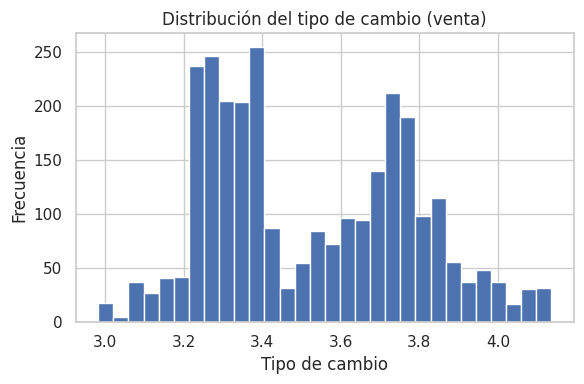

In [12]:
# c) ¿Las etiquetas del target están balanceadas?
print("\nc) Balance del target:")
if pd.api.types.is_numeric_dtype(df[tc_col]) and df[tc_col].nunique() > 20:
    print("   El target es numérico continuo, por lo que NO hablamos de clases balanceadas,")
    print("   sino de la distribución de valores. Mostramos un histograma:")
    plt.figure(figsize=(6,4))
    df[tc_col].hist(bins=30)
    plt.title('Distribución del tipo de cambio (venta)')
    plt.xlabel('Tipo de cambio')
    plt.ylabel('Frecuencia')
    plt.tight_layout()
    plt.show()
else:
    conteo = df[tc_col].value_counts()
    porcentaje = df[tc_col].value_counts(normalize=True) * 100
    print("Conteo por clase:\n", conteo)
    print("\nPorcentaje por clase (%):\n", porcentaje.round(2))
    plt.figure(figsize=(6,4))
    conteo.plot(kind='bar')
    plt.title('Distribución de clases del target')
    plt.xlabel('Clases')
    plt.ylabel('Número de registros')
    plt.tight_layout()
    plt.show()



d) Datos faltantes por columna:
TC                0
dia               0
mes               0
anio              0
fecha             0
dia_semana        0
inflacion_peru    0
precio_cobre      0
precio_oro        0
precio_zinc       0
pbi               0
reservas          0
interv_bcrp       0
inflacion_usa     0
dtype: int64

Porcentaje de datos faltantes (%):
TC                0.0
dia               0.0
mes               0.0
anio              0.0
fecha             0.0
dia_semana        0.0
inflacion_peru    0.0
precio_cobre      0.0
precio_oro        0.0
precio_zinc       0.0
pbi               0.0
reservas          0.0
interv_bcrp       0.0
inflacion_usa     0.0
dtype: float64


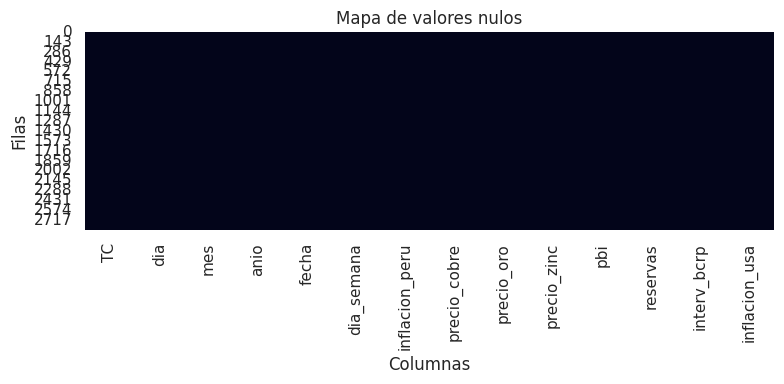

In [13]:
# d) ¿Hay datos faltantes?
print("\nd) Datos faltantes por columna:")
print(df.isnull().sum())

print("\nPorcentaje de datos faltantes (%):")
print((df.isnull().mean() * 100).round(4))

plt.figure(figsize=(8,4))
sns.heatmap(df.isnull(), cbar=False)
plt.title('Mapa de valores nulos')
plt.xlabel('Columnas')
plt.ylabel('Filas')
plt.tight_layout()
plt.show()


In [14]:
# e) ¿Hay datos fuera de serie? (outliers)
print("\ne) Detección de outliers con IQR:")

numeric_df = df.select_dtypes(include='number')
num_cols = numeric_df.columns.tolist()
print("Columnas numéricas:", num_cols)

for col in num_cols:
    Q1 = numeric_df[col].quantile(0.25)
    Q3 = numeric_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = numeric_df[(numeric_df[col] < lower) | (numeric_df[col] > upper)]
    print(f"   - {col}: {outliers.shape[0]} outliers")


e) Detección de outliers con IQR:
Columnas numéricas: ['TC', 'dia', 'anio', 'dia_semana', 'inflacion_peru', 'precio_cobre', 'precio_oro', 'precio_zinc', 'pbi', 'reservas', 'interv_bcrp', 'inflacion_usa']
   - TC: 0 outliers
   - dia: 0 outliers
   - anio: 0 outliers
   - dia_semana: 0 outliers
   - inflacion_peru: 304 outliers
   - precio_cobre: 0 outliers
   - precio_oro: 199 outliers
   - precio_zinc: 44 outliers
   - pbi: 43 outliers
   - reservas: 0 outliers
   - interv_bcrp: 0 outliers
   - inflacion_usa: 0 outliers


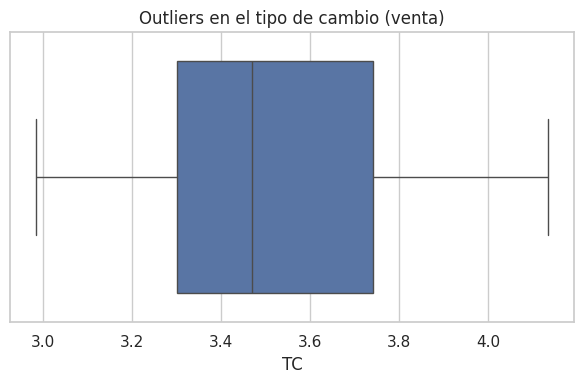

In [15]:
# Boxplot solo del tipo de cambio
plt.figure(figsize=(6,4))
sns.boxplot(x=df[tc_col])
plt.title('Outliers en el tipo de cambio (venta)')
plt.tight_layout()
plt.show()

In [16]:
# f) ¿Qué tipos de datos son? (numéricos, ordinales, etc.)
print("\nf) Tipos de datos por columna:")
print(df.dtypes)

print("\nColumnas numéricas:", numeric_df.columns.tolist())
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print("Columnas categóricas / texto:", cat_cols)


f) Tipos de datos por columna:
TC                float64
dia                 int64
mes                object
anio                int64
fecha              object
dia_semana          int64
inflacion_peru    float64
precio_cobre      float64
precio_oro        float64
precio_zinc       float64
pbi               float64
reservas          float64
interv_bcrp         int64
inflacion_usa     float64
dtype: object

Columnas numéricas: ['TC', 'dia', 'anio', 'dia_semana', 'inflacion_peru', 'precio_cobre', 'precio_oro', 'precio_zinc', 'pbi', 'reservas', 'interv_bcrp', 'inflacion_usa']
Columnas categóricas / texto: ['mes', 'fecha']




g) Correlación entre variables numéricas:
                      TC       dia      anio  dia_semana  inflacion_peru  \
TC              1.000000 -0.001812  0.748187   -0.006519        0.517709   
dia            -0.001812  1.000000  0.003030    0.002930       -0.001212   
anio            0.748187  0.003030  1.000000    0.005305        0.150774   
dia_semana     -0.006519  0.002930  0.005305    1.000000       -0.002392   
inflacion_peru  0.517709 -0.001212  0.150774   -0.002392        1.000000   
precio_cobre    0.757026  0.000869  0.858874    0.005353        0.240259   
precio_oro      0.504776  0.004896  0.869441    0.011374       -0.086962   
precio_zinc     0.447672 -0.000372  0.450577    0.001512        0.279823   
pbi             0.527608  0.013953  0.642676    0.006493        0.124374   
reservas        0.703073  0.005045  0.905587    0.010308        0.123098   
interv_bcrp    -0.012682  0.003126  0.015616    0.014041       -0.022253   
inflacion_usa   0.382156  0.005160  0.743440

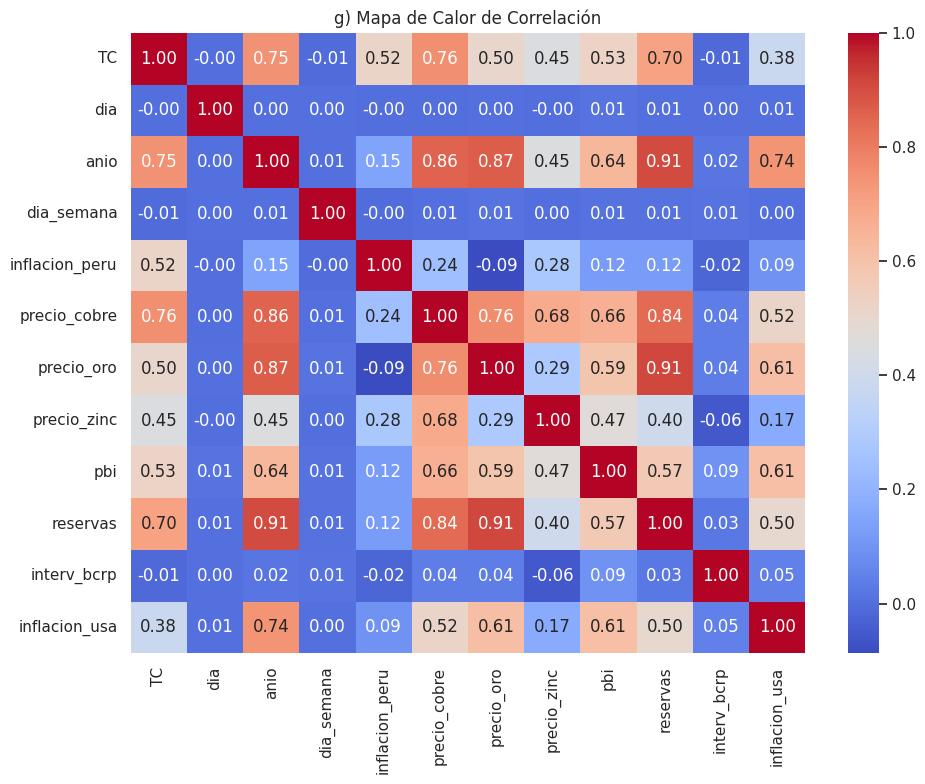

In [17]:
# g) ¿Hay correlación entre los datos?
print("\n\ng) Correlación entre variables numéricas:")

corr = numeric_df.corr()
print(corr)

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('g) Mapa de Calor de Correlación')
plt.tight_layout()
plt.show()


# 1.2 PROCESAMIENTO DE DATOS

In [18]:
print("\n========================")
print("1.2 PROCESAMIENTO DE DATOS")
print("========================")

df_proc = df.copy()


1.2 PROCESAMIENTO DE DATOS


In [19]:
# 1) Ajuste de tipos: convertir 'fecha' a datetime y usarla como índice temporal
df_proc['fecha'] = pd.to_datetime(df_proc['fecha'], format='%d/%m/%Y', errors='coerce')
df_proc = df_proc.set_index('fecha').sort_index()
print("-> 'fecha' convertida a datetime y establecida como índice temporal.")

-> 'fecha' convertida a datetime y establecida como índice temporal.


In [20]:
# 2) Creación del Target de Volatilidad: rendimientos logarítmicos del tipo de cambio de venta
df_proc['Rendimientos_log'] = np.log(df_proc[tc_col] / df_proc[tc_col].shift(1))
df_proc.dropna(subset=['Rendimientos_log'], inplace=True)
print("-> Target 'Rendimientos_log' creado correctamente (log(TC_t / TC_{t-1})).")

print("\nPreview con rendimientos:")
print(df_proc[[tc_col, 'Rendimientos_log']].head())

-> Target 'Rendimientos_log' creado correctamente (log(TC_t / TC_{t-1})).

Preview con rendimientos:
               TC  Rendimientos_log
fecha                              
2015-01-02  2.989          0.000000
2015-01-05  2.992          0.001003
2015-01-06  2.983         -0.003013
2015-01-07  2.987          0.001340
2015-01-08  2.989          0.000669


In [21]:
# 3) Escalado de variables numéricas para modelos posteriores (Agregado)
from sklearn.preprocessing import MinMaxScaler

feature_cols = [c for c in df_proc.select_dtypes(include='number').columns
                if c != 'Rendimientos_log']

scaler = MinMaxScaler()
df_scaled = df_proc.copy()
df_scaled[feature_cols] = scaler.fit_transform(df_scaled[feature_cols])

print("\n-> Se generó 'df_scaled' con las variables numéricas escaladas entre 0 y 1 (excepto el target).")
print("Shape df_proc:", df_proc.shape)
print("Shape df_scaled:", df_scaled.shape)


-> Se generó 'df_scaled' con las variables numéricas escaladas entre 0 y 1 (excepto el target).
Shape df_proc: (2850, 14)
Shape df_scaled: (2850, 14)


###AGREGADO JOHN BORRADOR GARCH

In [22]:
# -------------------------------
# CELDA A: Imputación y creación de lags/volatilidad
# -------------------------------
# Rellenar NaN (si quedan) de forma temporal: forward / backward
df_scaled = df_scaled.fillna(method="ffill").fillna(method="bfill")

# Crear lags, diferencia y volatilidad sobre la versión NO escalada (usar df_proc que tiene índice temporal)
df_ts = df_proc.copy()   # tiene 'fecha' como índice y target Rendimientos_log creado
# Asegúrate de que 'TC' exista en df_ts
df_ts['TC_lag1'] = df_ts['TC'].shift(1)
df_ts['TC_lag3'] = df_ts['TC'].shift(3)
df_ts['TC_lag7'] = df_ts['TC'].shift(7)
df_ts['TC_diff1'] = df_ts['TC'] - df_ts['TC_lag1']
df_ts['TC_vol7'] = df_ts['TC'].rolling(window=7).std()
df_ts['TC_vol30'] = df_ts['TC'].rolling(window=30).std()

# Eliminar filas con NaN resultantes por lags/rolling
df_ts = df_ts.dropna()

# Re-escalar las nuevas features (luego uniremos con df_scaled)
from sklearn.preprocessing import MinMaxScaler
scaler2 = MinMaxScaler()
new_feats = ['TC_lag1','TC_lag3','TC_lag7','TC_diff1','TC_vol7','TC_vol30']
df_ts[new_feats] = scaler2.fit_transform(df_ts[new_feats])

# Ahora construimos df_final uniendo las columnas escaladas originales (ya en df_scaled)
# (df_scaled tiene Rendimientos_log target y fue escalado; su índice es fecha)
df_final = df_scaled.loc[df_ts.index].copy()  # alinear por índice fecha
df_final[new_feats] = df_ts[new_feats]

# ❌ Quitar TC porque causa leakage (target = función de TC)
if "TC" in df_final.columns:
    df_final = df_final.drop(columns=["TC"])


print("df_final shape:", df_final.shape)
print("NaNs restantes:\n", df_final.isna().sum())


df_final shape: (2821, 19)
NaNs restantes:
 dia                 0
mes                 0
anio                0
dia_semana          0
inflacion_peru      0
precio_cobre        0
precio_oro          0
precio_zinc         0
pbi                 0
reservas            0
interv_bcrp         0
inflacion_usa       0
Rendimientos_log    0
TC_lag1             0
TC_lag3             0
TC_lag7             0
TC_diff1            0
TC_vol7             0
TC_vol30            0
dtype: int64


/tmp/ipython-input-2480795900.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_scaled = df_scaled.fillna(method="ffill").fillna(method="bfill")


In [23]:
# -------------------------------
# CELDA B: Selección automática de features (correlación + reducción multicolinealidad)
# -------------------------------
# Calculamos correlación absoluta con el target (Rendimientos_log si tu objetivo es predecir rendimientos;
# si deseas predecir TC directamente, usa 'TC' como target)
target = 'Rendimientos_log'  # según tu pipeline
# Mantener solo columnas numéricas (evita errores en correlación)
# Solo columnas numéricas y SIN el target dentro de X
# Mantener solo columnas numéricas
df_final = df_final.select_dtypes(include='number')

# ❗ Eliminar TC_diff1 si no quieres usarla como feature
if "TC_diff1" in df_final.columns:
    df_final = df_final.drop(columns=["TC_diff1"])

# Recalcular correlaciones SIN TC_diff1
corr_with_target = df_final.corr()[target].abs().sort_values(ascending=False)
print("Correlación absoluta con target (sin TC_diff1):\n", corr_with_target)



# Quitar TC_diff1 de la lista de candidatos
corr_with_target = corr_with_target.drop("TC_diff1", errors="ignore")

# Tomar las top_k más correlacionadas (ej: 12)
top_k = 6
candidates = corr_with_target.index.drop(target).tolist()[:top_k]

# Remover multicolinealidad: si dos features tienen corr>0.85 entre sí, quitar la de menor corr con target
def remove_multicollinear(df, feats, thresh=0.85):
    feats = feats.copy()
    corrmat = df[feats].corr().abs()
    to_drop = set()
    for i in range(len(feats)):
        for j in range(i+1, len(feats)):
            fi, fj = feats[i], feats[j]
            if corrmat.loc[fi, fj] > thresh:
                # drop the one with lower corr with target
                if corr_with_target[fi] >= corr_with_target[fj]:
                    to_drop.add(fj)
                else:
                    to_drop.add(fi)
    return [f for f in feats if f not in to_drop]

selected_feats = remove_multicollinear(df_final, candidates, thresh=0.85)
print("Selected features after removing multicollinearity:", selected_feats)


Correlación absoluta con target (sin TC_diff1):
 Rendimientos_log    1.000000
dia_semana          0.086711
TC_lag3             0.044278
TC_lag7             0.041967
precio_oro          0.037441
TC_lag1             0.035375
inflacion_usa       0.033211
anio                0.031117
precio_zinc         0.029611
precio_cobre        0.028133
pbi                 0.027922
reservas            0.027794
dia                 0.026125
TC_vol30            0.015682
TC_vol7             0.015342
inflacion_peru      0.010016
interv_bcrp         0.008894
Name: Rendimientos_log, dtype: float64
Selected features after removing multicollinearity: ['dia_semana', 'TC_lag3', 'precio_oro', 'inflacion_usa']


In [24]:
# -------------------------------
# CELDA C: Preparar X/y y split (sin shuffle para respetar temporalidad)
# -------------------------------
X = df_final[selected_feats]
y = df_final[target]   # Rendimientos_log

# Split temporal manual (mejor práctica para series financieras)
train_size = int(len(X) * 0.8)

X_train = X.iloc[:train_size]
X_test  = X.iloc[train_size:]
y_train = y.iloc[:train_size]
y_test  = y.iloc[train_size:]


print("Tamaños -> X_train:", X_train.shape, "X_test:", X_test.shape)


Tamaños -> X_train: (2256, 4) X_test: (565, 4)


In [25]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train)
X_test[X_test.columns] = scaler.transform(X_test)


/tmp/ipython-input-2711304531.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[X_train.columns] = scaler.fit_transform(X_train)
/tmp/ipython-input-2711304531.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[X_test.columns] = scaler.transform(X_test)


In [26]:
# -------------------------------
# CELDA D: LazyPredict para comparar modelos rápidamente
# -------------------------------

from lazypredict.Supervised import LazyRegressor

reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

display(models.head(10))
best_name = models.index[0]
print("Mejor según LazyPredict:", best_name)


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 385
[LightGBM] [Info] Number of data points in the train set: 2256, number of used features: 4
[LightGBM] [Info] Start training from score 0.000094


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
OrthogonalMatchingPursuitCV,-0.00,0.01,0.00,0.02
OrthogonalMatchingPursuit,-0.00,0.01,0.00,0.02
TweedieRegressor,-0.00,0.01,0.00,0.03
QuantileRegressor,-0.01,-0.00,0.00,0.98
PassiveAggressiveRegressor,-0.01,-0.00,0.00,0.03
ElasticNet,-0.02,-0.01,0.00,0.03
LassoLars,-0.02,-0.01,0.00,0.03
DummyRegressor,-0.02,-0.01,0.00,0.05
Lasso,-0.02,-0.01,0.00,0.03


Mejor según LazyPredict: OrthogonalMatchingPursuitCV


                        Constant Mean - GARCH Model Results                         
Dep. Variable:             Rendimientos_log   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -7022.03
Distribution:      Standardized Student's t   AIC:                           14054.1
Method:                  Maximum Likelihood   BIC:                           14083.8
                                              No. Observations:                 2850
Date:                      Wed, Dec 10 2025   Df Residuals:                     2849
Time:                              09:22:15   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

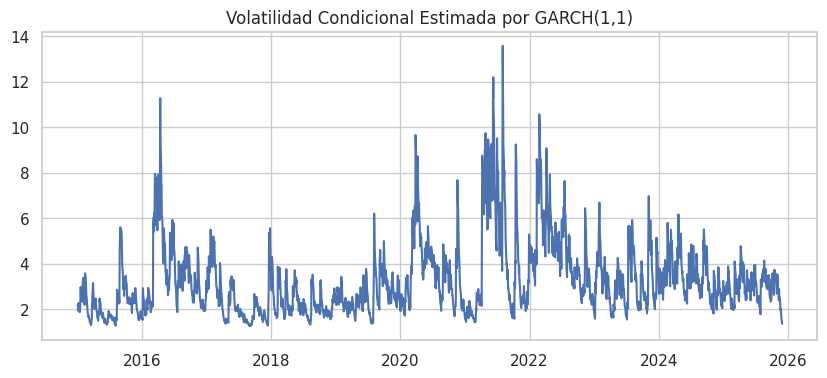

In [27]:

# -------------------------------
# GARCH(1,1) – versión compatible con Colab
# -------------------------------

!pip install arch --quiet

from arch import arch_model

returns = df_proc["Rendimientos_log"].dropna()
scale_factor = 1000        # Puedes usar 500 o 1000
returns_scaled = returns * scale_factor


# Modelo GARCH básico con t-student
model = arch_model(returns_scaled, vol="GARCH", p=1, q=1, dist="t", rescale=False)


# Ajuste (forma compatible con Colab)
garch_result = model.fit(update_freq=5, disp="off")
print(garch_result.summary())

# ================================
# PRONÓSTICO DE VOLATILIDAD
# ================================
forecast = garch_result.forecast(horizon=5)
vol_pred_scaled = forecast.variance.iloc[-1]
vol_pred = vol_pred_scaled / (scale_factor**2)


print("\nVOLATILIDAD PREDICHA (5 días):")
pd.set_option("display.float_format", "{:.10f}".format)
print(vol_pred)


vol_pred_pct = np.sqrt(vol_pred) * 100    # volatilidad diaria en %
print("\nVolatilidad diaria (%) :")
print(vol_pred_pct)



# ================================
# Gráfico de volatilidad condicional
# ================================
plt.figure(figsize=(10,4))
plt.plot(garch_result.conditional_volatility)
plt.title("Volatilidad Condicional Estimada por GARCH(1,1)")
plt.show()



In [28]:
print("Varianza de retornos:", returns.var())
print("Máximo retorno absoluto:", returns.abs().max())
print("Percentiles:", returns.abs().quantile([0.5, 0.9, 0.99]))


Varianza de retornos: 1.1843730954745235e-05
Máximo retorno absoluto: 0.030122759455108297
Percentiles: 0.5000000000   0.0015741840
0.9000000000   0.0053990361
0.9900000000   0.0120348391
Name: Rendimientos_log, dtype: float64


##Avance para el dia jueves, Borrador GRUPO

In [29]:
# ======================================================
# 2. EXPLORACIÓN DE MODELOS (JUEVES) - REGRESIÓN
# ======================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import joblib

sns.set(style="whitegrid")

# ======================================================
# 2.0. DEFINICIÓN DE FEATURES Y TARGET
#     Usamos df_scaled del bloque anterior
# ======================================================

print("\n=== 2.0 Definición de X e y ===")

# Columnas numéricas que NO son el target (ya escaladas en df_scaled)
feature_cols = [c for c in df_scaled.select_dtypes(include='number').columns
                if c != 'Rendimientos_log']

X = df_scaled[feature_cols]
y = df_scaled['Rendimientos_log']

print("Features usadas:", feature_cols)
print("Shape X:", X.shape, "Shape y:", y.shape)

# Split respetando el orden temporal (no mezclamos)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    shuffle=False
)

print("Train:", X_train.shape, "Test:", X_test.shape)

# ======================================================
# 2.1.a USO DE LAZYPREDICT (LazyRegressor)
# ======================================================

print("\n=== 2.1.a Uso de LazyPredict (LazyRegressor) ===")

!pip install -q lazypredict

from lazypredict.Supervised import LazyRegressor

lazy_reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)

models, predictions = lazy_reg.fit(X_train, X_test, y_train, y_test)

# Ordenamos por R2 descendente (entre más alto mejor)
models_sorted = models.sort_values(by="R-Squared", ascending=False)
print("\nRanking de modelos (top 10):")
print(models_sorted.head(10))

# ======================================================
# 2.1.b SELECCIÓN DE 1 MODELO Y NUEVO ENTRENAMIENTO
#     (Tomamos RandomForestRegressor, que suele estar arriba)
# ======================================================

print("\n=== 2.1.b Selección y nuevo entrenamiento ===")

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred_base = rf.predict(X_test)

print("Métricas modelo base (RandomForestRegressor con hiperparámetros por defecto extendidos):")
print("  MAE   :", mean_absolute_error(y_test, y_pred_base))
print("  RMSE  :", np.sqrt(mean_squared_error(y_test, y_pred_base)))
print("  R2    :", r2_score(y_test, y_pred_base))

# ======================================================
# 2.1.c OPTIMIZACIÓN DE HIPERPARÁMETROS CON CV=5
#     Usamos GridSearchCV
# ======================================================

print("\n=== 2.1.c Optimización de hiperparámetros (CV=5) ===")

param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("\nMejores hiperparámetros encontrados:")
print(grid_search.best_params_)

best_rf = grid_search.best_estimator_

# ======================================================
# 2.1.d ANÁLISIS DE MÉTRICAS DEL MEJOR MODELO
# ======================================================

print("\n=== 2.1.d Métricas del mejor modelo (RandomForest optimizado) ===")

y_pred_best = best_rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_best)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2 = r2_score(y_test, y_pred_best)

print("  MAE   :", mae)
print("  RMSE  :", rmse)
print("  R2    :", r2)

# Comparación rápida vs modelo base
print("\nComparación vs modelo base:")
print("  Mejora MAE  :", mean_absolute_error(y_test, y_pred_base) - mae)
print("  Mejora RMSE :", np.sqrt(mean_squared_error(y_test, y_pred_base)) - rmse)
print("  Mejora R2   :", r2 - r2_score(y_test, y_pred_base))

# (Opcional) gráfico de y real vs predicho
plt.figure(figsize=(8,4))
plt.plot(y_test.values, label='Real', alpha=0.8)
plt.plot(y_pred_best, label='Predicho (best RF)', alpha=0.8)
plt.title('Rendimientos logarítmicos: real vs predicho')
plt.legend()
plt.tight_layout()
plt.show()

# ======================================================
# 2.2 GUARDAR EL MEJOR MODELO
# ======================================================

print("\n=== 2.2 Guardar el mejor modelo ===")

joblib.dump(best_rf, 'mejor_modelo_rf_tc.pkl')
print("Modelo guardado como 'mejor_modelo_rf_tc.pkl'")

# En Colab, para descargar:
# from google.colab import files
# files.download('mejor_modelo_rf_tc.pkl')



=== 2.0 Definición de X e y ===
Features usadas: ['TC', 'dia', 'anio', 'dia_semana', 'inflacion_peru', 'precio_cobre', 'precio_oro', 'precio_zinc', 'pbi', 'reservas', 'interv_bcrp', 'inflacion_usa']
Shape X: (2850, 12) Shape y: (2850,)
Train: (2280, 12) Test: (570, 12)

=== 2.1.a Uso de LazyPredict (LazyRegressor) ===


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1089
[LightGBM] [Info] Number of data points in the train set: 2280, number of used features: 12
[LightGBM] [Info] Start training from score 0.000106

Ranking de modelos (top 10):
                             Adjusted R-Squared     R-Squared         RMSE  \
Model                                                                        
OrthogonalMatchingPursuitCV       -0.0154517481  0.0059637545 0.0031001690   
OrthogonalMatchingPursuit         -0.0154517481  0.0059637545 0.0031001690   
LassoLarsIC                       -0.0173044815  0.0041500946 0.0031029959   
LarsCV                            -0.0202801151  0.0012372160 0.0031075307   
QuantileRegressor                 -0.0260352108 -0.0043965069 0.0031162827   
PassiveAggressiveRe

KeyboardInterrupt: 

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Modelo base
lr = LinearRegression()

# ===== FORWARD: SOLO 3 VARIABLES =====
sfs_3 = SequentialFeatureSelector(
    lr,
    n_features_to_select=3,   # 👈 Aquí lo obligamos a elegir solo 3
    direction="forward",
    scoring="r2",
    cv=5,                     # puedes usar TimeSeriesSplit si quieres ser más fino
    n_jobs=-1
)

print("=== Entrenando selección forward (k = 3) ===")
sfs_3.fit(X_train, y_train)

# Columnas seleccionadas
selected_cols = X_train.columns[sfs_3.get_support()]
print("\nVariables seleccionadas (k = 3):")
for c in selected_cols:
    print(" -", c)

# ===== Entrenamos el modelo solo con esas 3 =====
X_train_sel = X_train[selected_cols]
X_test_sel  = X_test[selected_cols]

# Imputar posibles NaN
imputer = SimpleImputer(strategy="median")
X_train_sel_imp = imputer.fit_transform(X_train_sel)
X_test_sel_imp  = imputer.transform(X_test_sel)

lr.fit(X_train_sel_imp, y_train)
y_pred = lr.predict(X_test_sel_imp)

r2   = r2_score(y_test, y_pred)
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\nMétricas modelo lineal con 3 variables (forward):")
print(f"  R2   : {r2:.4f}")
print(f"  MAE  : {mae:.6f}")
print(f"  RMSE : {rmse:.6f}")



